In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from matplotlib import style
style.use('dark_background')

# Import necessary libraries.

In [14]:
ticker = 'F'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start='2010-01-01', end='2010-07-01')
print(data)

# Pull data from yfinance

                Open      High       Low     Close     Volume  Dividends  \
Date                                                                       
2009-12-31  6.692592  6.705924  6.612601  6.665928   31253700          0   
2010-01-04  6.779250  6.852575  6.699259  6.852575   60855800          0   
2010-01-05  6.965897  7.492505  6.932567  7.305860  215620200          0   
2010-01-06  7.472506  7.639155  7.419179  7.579161  200070600          0   
2010-01-07  7.639155  7.792471  7.545832  7.772473  130201700          0   
...              ...       ...       ...       ...        ...        ...   
2010-06-24  7.325858  7.352521  7.092550  7.185873   74449200          0   
2010-06-25  7.165876  7.179208  6.945900  7.165876  148168400          0   
2010-06-28  7.145877  7.172541  6.952565  6.952565   57994700          0   
2010-06-29  6.745922  6.759254  6.499283  6.585940  124866100          0   
2010-06-30  6.732588  7.012557  6.692592  6.719256  182831300          0   

           

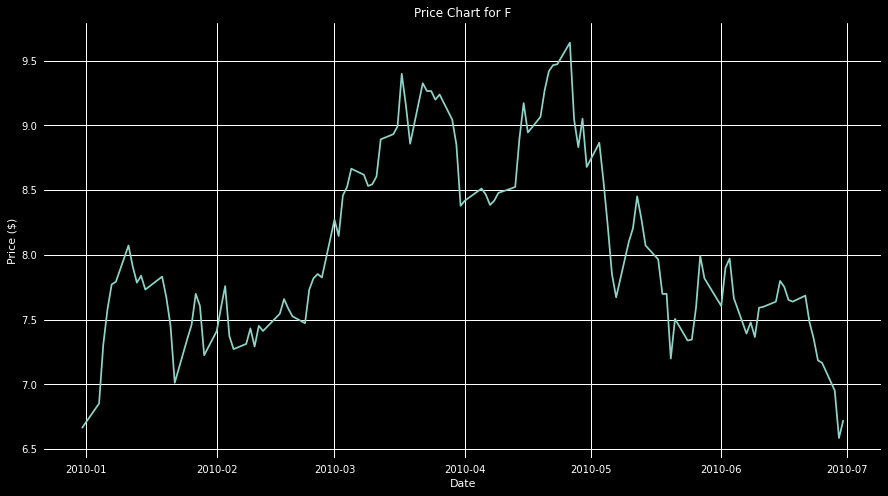

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
plt.title(f'Price Chart for {ticker}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

# Plot data.

In [16]:
data['local_max'] = data['Close'][
  (data['Close'].shift(1) < data['Close']) &
  (data['Close'].shift(-1) < data['Close'])]

data['local_min'] = data['Close'][
  (data['Close'].shift(1) > data['Close']) &
  (data['Close'].shift(-1) > data['Close'])]

print(data)

# Define local maxima and local minima points.

                Open      High       Low     Close     Volume  Dividends  \
Date                                                                       
2009-12-31  6.692592  6.705924  6.612601  6.665928   31253700          0   
2010-01-04  6.779250  6.852575  6.699259  6.852575   60855800          0   
2010-01-05  6.965897  7.492505  6.932567  7.305860  215620200          0   
2010-01-06  7.472506  7.639155  7.419179  7.579161  200070600          0   
2010-01-07  7.639155  7.792471  7.545832  7.772473  130201700          0   
...              ...       ...       ...       ...        ...        ...   
2010-06-24  7.325858  7.352521  7.092550  7.185873   74449200          0   
2010-06-25  7.165876  7.179208  6.945900  7.165876  148168400          0   
2010-06-28  7.145877  7.172541  6.952565  6.952565   57994700          0   
2010-06-29  6.745922  6.759254  6.499283  6.585940  124866100          0   
2010-06-30  6.732588  7.012557  6.692592  6.719256  182831300          0   

           

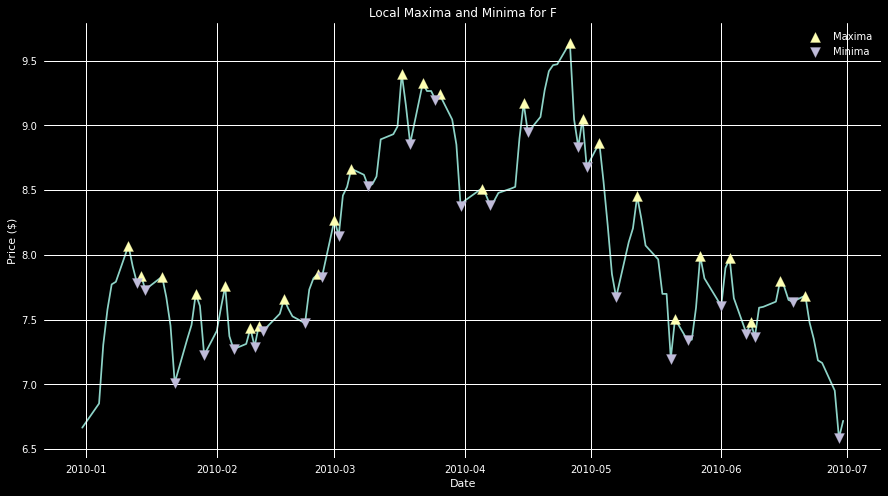

In [17]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.index, data['local_max'], s=100,
  label='Maxima', marker='^', c=colors[1])
plt.scatter(data.index, data['local_min'], s=100,
  label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima for {ticker}')
plt.legend()
plt.show()

# Plot pivot points (local maxima and minima points)

# We need to do some kind of filtering or develop some type of rules 
# to identify peaks and troughs so we don't end up with such a noisy 
# signal like we have in the plot below. Additionally, we need to make 
# sure we aren't looking ahead in our data when doing so.

# Further, we have one more complication, we aren't just looking for 
# new peaks and troughs, but a succession of peaks and troughs to make a 
# divergence indicator. To extract "higher highs" out of a signal, we need 
# at least two peaks with the second peak being higher than the first.

In [18]:
from scipy.signal import argrelextrema

# This function will give us the max and min values from a time series. We simply need to pass our data, 
# tell it whether we're looking for maxima or minima values, and then indicate how many data points to 
# either side we're going to look. As shown above, we don't necessarily want to get every local max/min, 
# instead we can look in wider areas to pull out peaks for our divergence indicator.

# Take a look at the example below where we wait for 5 data points (order argument) to make our selection.

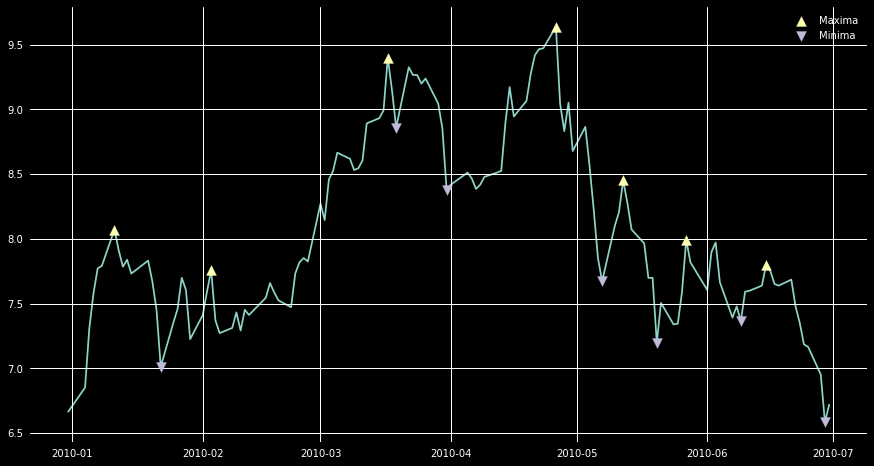

In [19]:
max_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]  # We recommend using DataFrame.to_numpy() instead of DataFrame.values
min_idx = argrelextrema(data['Close'].values, np.less, order=5)[0]  # We recommend using DataFrame.to_numpy() instead of DataFrame.values
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)
plt.scatter(data.iloc[max_idx].index, data.iloc[max_idx]['Close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(data.iloc[min_idx].index, data.iloc[min_idx]['Close'],
  label='Minima', s=100, color=colors[2], marker='v')

plt.legend()
plt.show()

#T his plot looks much more like what we'd expect when pulling out peaks and troughs.

In [20]:
# Our next step is going to look for consecutive peaks or troughs so we can get "higher highs",
# "lower lows", "lower highs", or "higher lows". Ultimately we'll have four different cases 
# to look for which will all follow very similar logic. Right now, let's just look cases where 
# there are at least two consecutive "higher highs."

# To do this, we're going to have to loop over our indices and check the values against the 
# previous result. If the new peak is greater than the previous peak, we can append it to a list
# and move on, otherwise we start over with this new peak and look at the next one.


In [21]:
from collections import deque
# Get K consecutive higher peaks
K = 2
high_idx = argrelextrema(data['Close'].values, np.greater, order=5)[0]  # We recommend using DataFrame.to_numpy() instead of DataFrame.values
highs = data.iloc[high_idx]['Close']

extrema = []
ex_deque = deque(maxlen=K)
for i, idx in enumerate(high_idx):
  if i == 0:
    ex_deque.append(idx)
    continue
  if highs[i] < highs[i-1]:
    ex_deque.clear()

  ex_deque.append(idx)
  if len(ex_deque) == K:
    # K-consecutive higher highs found
    extrema.append(ex_deque.copy())


In [22]:
# From the plot above, we should find two sets of consecutive peaks with K=2. And printing out our extrema list, that's what we see.
print(extrema)

[deque([22, 51], maxlen=2), deque([51, 78], maxlen=2)]


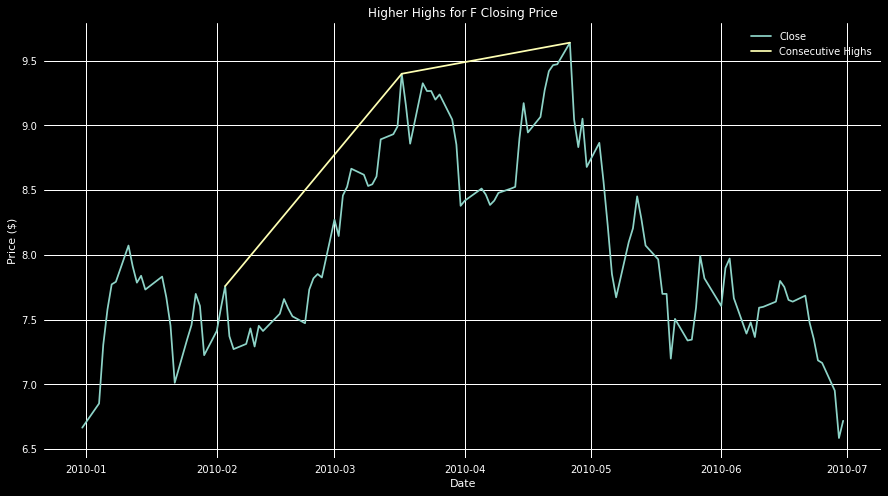

In [23]:
# Let's also plot this:

close = data['Close'].values  # We recommend using DataFrame.to_numpy() instead of DataFrame.values
dates = data.index

plt.figure(figsize=(15, 8))
plt.plot(data['Close'])
_ = [plt.plot(dates[i], close[i], c=colors[1]) for i in extrema]
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Higher Highs for {ticker} Closing Price')
plt.legend(['Close', 'Consecutive Highs'])
plt.show()

In [24]:
# We've pulled out our consecutive highs, so now let's put some functions together to get lower lows, lower highs, and higher lows: